In [1]:
import random
import pandas as pd
from datetime import datetime, timedelta


def generate_synthetic_record():
    sim_swap_time_gap_minutes = random.randint(0, 10080)  # up to 7 days
    device_change_flag = random.choice([0, 1])
    sim_type_change_flag = random.choice([0, 1])
    imsi_change_flag = random.choice([0, 1])
    iccid_change_flag = random.choice([0, 1])
    otp_and_sim_change_geo_hash_length = round(random.uniform(0.0, 1.0), 2)

    # New features
    recent_sim_activation_days = random.randint(0, 365)
    num_sim_changes_last_30d = random.randint(0, 5)
    previous_sim_holder_tenure_days = random.randint(0, 1095)  # Up to 3 years
    account_age_days = random.randint(1, 1825)  # Up to 5 years
    ip_change_flag = random.choice([0, 1])

    # Sim swap flag logic (simple heuristic)
    identity_shift_score = device_change_flag + sim_type_change_flag + imsi_change_flag + iccid_change_flag
    geo_risk_score = 1 - otp_and_sim_change_geo_hash_length
    time_urgency_score = 1 - min(sim_swap_time_gap_minutes, 10080) / 10080

    fraud_score = (
            0.3 * identity_shift_score +
            0.2 * geo_risk_score +
            0.2 * time_urgency_score +
            0.1 * (1 if recent_sim_activation_days < 7 else 0) +
            0.1 * (1 if num_sim_changes_last_30d >= 2 else 0) +
            0.1 * ip_change_flag
    )
    sim_swap_flag = 1 if fraud_score > 0.7 else 0

    return {
        "sim_swap_time_gap_minutes": sim_swap_time_gap_minutes,
        "device_change_flag": device_change_flag,
        "sim_type_change_flag": sim_type_change_flag,
        "imsi_change_flag": imsi_change_flag,
        "iccid_change_flag": iccid_change_flag,
        "otp_and_sim_change_geo_hash_length": otp_and_sim_change_geo_hash_length,
        "recent_sim_activation_days": recent_sim_activation_days,
        "num_sim_changes_last_30d": num_sim_changes_last_30d,
        "previous_sim_holder_tenure_days": previous_sim_holder_tenure_days,
        "account_age_days": account_age_days,
        "ip_change_flag": ip_change_flag,
        "sim_swap_flag": sim_swap_flag
    }


def generate_dataset(n=50000):
    return pd.DataFrame([generate_synthetic_record() for _ in range(n)])


if __name__ == "__main__":
    df = generate_dataset(50000)
    df.to_csv("sim_swap_fraud_dataset_50000.csv", index=False)
    print("Dataset with 50,000 records saved as 'sim_swap_fraud_dataset_50000.csv'")


Dataset with 50,000 records saved as 'sim_swap_fraud_dataset_50000.csv'


In [2]:
import pandas as pd

# Load the labeled dataset (with 'sim_swap_flag')
df_raw = pd.read_csv("sim_swap_fraud_dataset_50000.csv")

# Preview the dataset
df_raw.head()

,sim_swap_time_gap_minutes,device_change_flag,sim_type_change_flag,imsi_change_flag,iccid_change_flag,otp_and_sim_change_geo_hash_length,recent_sim_activation_days,num_sim_changes_last_30d,previous_sim_holder_tenure_days,account_age_days,ip_change_flag,sim_swap_flag
0,8922,1,0,1,0,0.53,53,0,569,1603,0,1
1,6618,0,1,0,1,0.62,124,2,707,110,1,1
2,8147,0,0,1,0,0.97,65,0,242,1601,1,0
3,6659,0,0,1,0,0.45,299,4,838,1207,1,0
4,3047,1,1,0,1,0.22,292,4,678,1310,0,1


In [3]:
# Re-import necessary libraries (if needed)
import pandas as pd

# Load the original dataset
df_raw = pd.read_csv("sim_swap_fraud_dataset_50000.csv")

# Define enrichment function
def enrich_input(raw):
    enriched = raw.copy()

    # Derived features
    enriched['time_urgency_score'] = 1 - min(raw['sim_swap_time_gap_minutes'], 10080) / 10080
    enriched['identity_shift_score'] = sum([
        raw['device_change_flag'],
        raw['sim_type_change_flag'],
        raw['imsi_change_flag'],
        raw['iccid_change_flag']
    ])
    enriched['geo_risk_score'] = 1 - raw['otp_and_sim_change_geo_hash_length']

    # New enrichment based on additional features
    enriched['sim_activity_score'] = 1 - min(raw['recent_sim_activation_days'], 365) / 365
    enriched['account_risk_score'] = (
        raw['num_sim_changes_last_30d'] * 0.3 +
        (1 - min(raw['previous_sim_holder_tenure_days'], 3650) / 3650) * 0.3 +
        (1 - min(raw['account_age_days'], 3650) / 3650) * 0.3 +
        raw['ip_change_flag'] * 0.1
    )

    return enriched

# Apply enrichment to all rows
df_enriched = df_raw.apply(enrich_input, axis=1)

# Confirm new columns exist
df_enriched.head()


,sim_swap_time_gap_minutes,device_change_flag,sim_type_change_flag,imsi_change_flag,iccid_change_flag,otp_and_sim_change_geo_hash_length,recent_sim_activation_days,num_sim_changes_last_30d,previous_sim_holder_tenure_days,account_age_days,ip_change_flag,sim_swap_flag,time_urgency_score,identity_shift_score,geo_risk_score,sim_activity_score,account_risk_score
0,8922.0,1.0,0.0,1.0,0.0,0.53,53.0,0.0,569.0,1603.0,0.0,1.0,0.114881,2.0,0.47,0.854795,0.421479
1,6618.0,0.0,1.0,0.0,1.0,0.62,124.0,2.0,707.0,110.0,1.0,1.0,0.343452,2.0,0.38,0.660274,1.232849
2,8147.0,0.0,0.0,1.0,0.0,0.97,65.0,0.0,242.0,1601.0,1.0,0.0,0.191766,1.0,0.03,0.821918,0.548521
3,6659.0,0.0,0.0,1.0,0.0,0.45,299.0,4.0,838.0,1207.0,1.0,0.0,0.339385,1.0,0.55,0.180822,1.731918
4,3047.0,1.0,1.0,0.0,1.0,0.22,292.0,4.0,678.0,1310.0,0.0,1.0,0.697718,3.0,0.78,0.200000,1.636603


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Features and label
feature_columns = [
    "sim_swap_time_gap_minutes",
    "device_change_flag",
    "sim_type_change_flag",
    "imsi_change_flag",
    "iccid_change_flag",
    "otp_and_sim_change_geo_hash_length",
    "recent_sim_activation_days",
    "num_sim_changes_last_30d",
    "previous_sim_holder_tenure_days",
    "account_age_days",
    "ip_change_flag"
]
label_column = "sim_swap_flag"

X = df_enriched[feature_columns]
y = df_enriched[label_column]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model trained successfully!")


Model trained successfully!


In [5]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (fraud)
y_pred_class = model.predict(X_test)

# Helper function to convert probability to risk level
def classify_risk(prob):
    if prob >= 0.9:
        return "Very High"
    elif prob >= 0.7:
        return "High"
    elif prob >= 0.4:
        return "Medium"
    elif prob >= 0.2:
        return "Low"
    else:
        return "Very Low"

# Apply risk classification
risk_levels = [classify_risk(p) for p in y_pred_proba]

# Create results DataFrame
results_df = X_test.copy()
results_df['Actual_Label'] = y_test.values
results_df['Predicted_Label'] = y_pred_class
results_df['Fraud_Probability'] = y_pred_proba
results_df['Risk_Level'] = risk_levels

# Show sample predictions
results_df.head(10)


,sim_swap_time_gap_minutes,device_change_flag,sim_type_change_flag,imsi_change_flag,iccid_change_flag,otp_and_sim_change_geo_hash_length,recent_sim_activation_days,num_sim_changes_last_30d,previous_sim_holder_tenure_days,account_age_days,ip_change_flag,Actual_Label,Predicted_Label,Fraud_Probability,Risk_Level
41764,5503.0,0.0,0.0,1.0,0.0,0.43,356.0,5.0,617.0,43.0,0.0,0.0,0.0,0.02,Very Low
34325,6656.0,0.0,0.0,0.0,0.0,0.39,231.0,3.0,1013.0,461.0,0.0,0.0,0.0,0.00,Very Low
70,705.0,1.0,1.0,0.0,1.0,0.54,129.0,1.0,105.0,512.0,1.0,1.0,1.0,1.00,Very High
28067,5609.0,0.0,1.0,1.0,1.0,0.20,333.0,3.0,742.0,1280.0,0.0,1.0,1.0,1.00,Very High
32636,6904.0,0.0,1.0,0.0,0.0,0.13,223.0,4.0,805.0,129.0,0.0,0.0,0.0,0.06,Very Low
505,9921.0,0.0,0.0,1.0,0.0,0.40,61.0,1.0,155.0,430.0,0.0,0.0,0.0,0.04,Very Low
36527,8224.0,1.0,0.0,1.0,1.0,0.94,290.0,3.0,391.0,713.0,0.0,1.0,1.0,1.00,Very High
43388,9255.0,1.0,0.0,0.0,1.0,0.88,183.0,0.0,1069.0,327.0,0.0,0.0,0.0,0.27,Low
17744,9889.0,0.0,1.0,0.0,0.0,0.89,308.0,5.0,57.0,260.0,0.0,0.0,0.0,0.05,Very Low
34174,6143.0,1.0,0.0,0.0,1.0,0.13,314.0,5.0,445.0,765.0,0.0,1.0,1.0,0.99,Very High


Evaluate Model Performance

Let’s look at the performance metrics like accuracy, precision, recall, and F1 score, along with the confusion matrix:

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred_class, digits=4))

# Confusion matrix
print("🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

📊 Classification Report:
              precision    recall  f1-score   support

         0.0     0.9820    0.9868    0.9844      2661
         1.0     0.9952    0.9935    0.9943      7339

    accuracy                         0.9917     10000
   macro avg     0.9886    0.9902    0.9894     10000
weighted avg     0.9917    0.9917    0.9917     10000

🧮 Confusion Matrix:
[[2626   35]
 [  48 7291]]


Visualize Risk Level Distribution

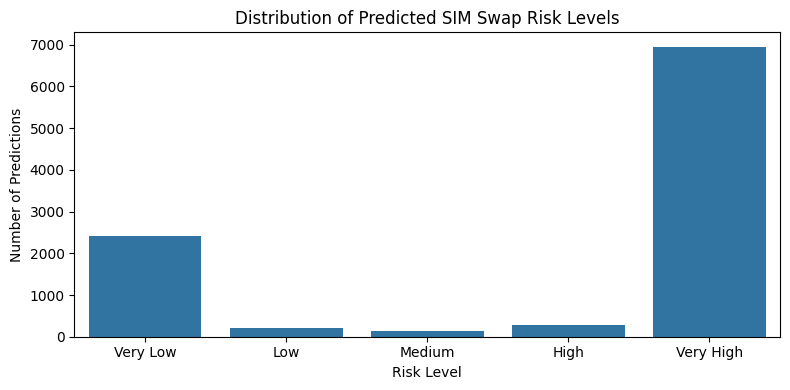

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=results_df, x="Risk_Level", order=["Very Low", "Low", "Medium", "High", "Very High"])
plt.title("Distribution of Predicted SIM Swap Risk Levels")
plt.xlabel("Risk Level")
plt.ylabel("Number of Predictions")
plt.tight_layout()
plt.show()


In [8]:
import joblib

# Save the trained model
joblib.dump(model, "sim_swap_fraud_rf_model.pkl")
print("✅ Model saved to sim_swap_fraud_rf_model.pkl")


✅ Model saved to sim_swap_fraud_rf_model.pkl


In [12]:
# Define a single raw input
custom_input = {
    "sim_swap_time_gap_minutes": 0,
    "device_change_flag": 0,
    "sim_type_change_flag": 0,
    "imsi_change_flag": 0,
    "iccid_change_flag": 0,
    "otp_and_sim_change_geo_hash_length": 0.0,
    "recent_sim_activation_days": 0,
    "num_sim_changes_last_30d": 0,
    "previous_sim_holder_tenure_days": 0,
    "account_age_days": 10000,
    "ip_change_flag": 1
}

# Enrich the input
enriched_input = enrich_input(custom_input)
input_df = pd.DataFrame([enriched_input])

# Ensure input has the correct feature order
input_features = input_df[feature_columns]

# Predict using trained model
pred_proba = model.predict_proba(input_features)[0][1]  # Probability of fraud
pred_class = model.predict(input_features)[0]

# Map probability to risk level
def map_risk_level(prob):
    if prob >= 0.90:
        return "Very High"
    elif prob >= 0.70:
        return "High"
    elif prob >= 0.40:
        return "Medium"
    elif prob >= 0.20:
        return "Low"
    else:
        return "Very Low"

risk_level = map_risk_level(pred_proba)

# Show results
print(f"🔍 Predicted Fraud Probability: {pred_proba:.4f}")
print(f"🔒 Classified as: {risk_level} Risk")
print(f"📌 Model Binary Class Prediction: {pred_class} (1 = Fraud, 0 = Normal)")


🔍 Predicted Fraud Probability: 0.1300
🔒 Classified as: Very Low Risk
📌 Model Binary Class Prediction: 0.0 (1 = Fraud, 0 = Normal)
